In [1]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from kagglehub import KaggleDatasetAdapter

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

c:\Users\Giuli\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_heart_disease = (kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "fedesoriano/heart-failure-prediction",
  "heart.csv",
))

In [3]:
df_heart_disease.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# TA -> Typical Angina
# ATA -> Atypical Angina
# NAP -> Non-Anginal Pain
# ASY -> Asymptomatic
df_heart_disease.ChestPainType.unique()

array(['ATA', 'NAP', 'ASY', 'TA'], dtype=object)

In [5]:
df_heart_disease.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [6]:
df_heart_disease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
df_heart_disease.HeartDisease.value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

In [8]:
df_heart_disease.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

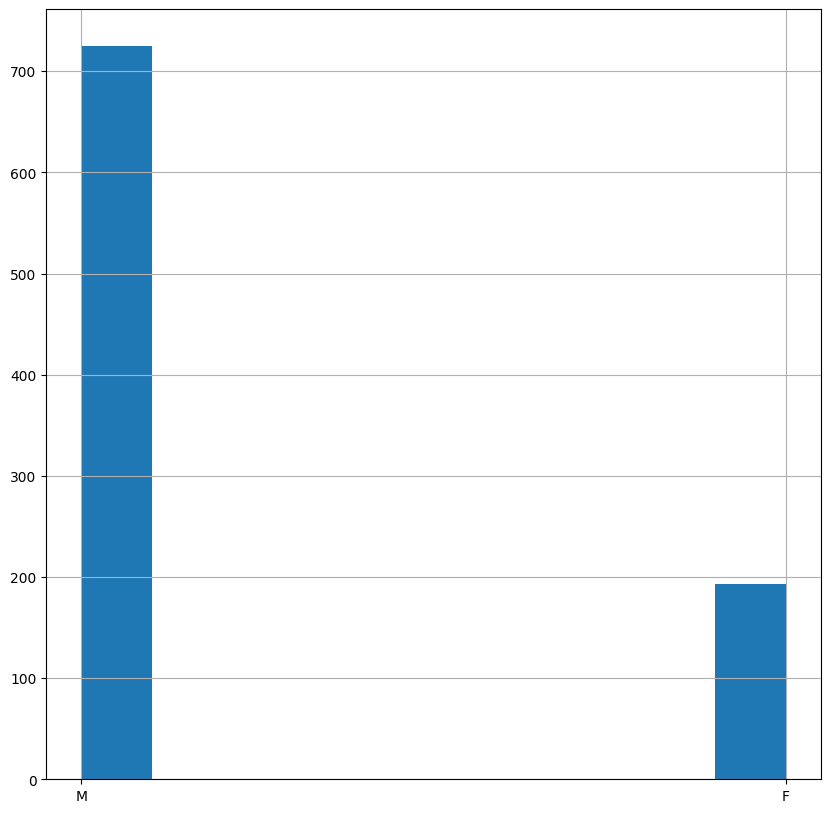

In [9]:
df_heart_disease.Sex.hist(figsize=(10,10))
plt.show()

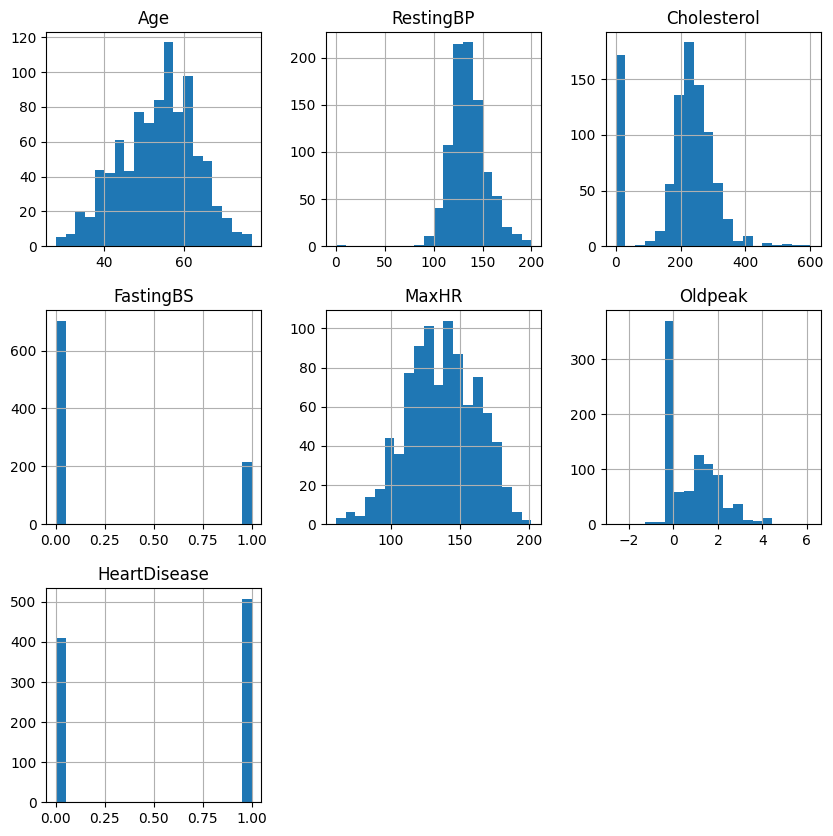

In [10]:
df_heart_disease.hist(bins=20, figsize=(10, 10))
plt.show()

In [11]:
df_heart_disease.loc[df_heart_disease['Cholesterol'] == 0, 'Cholesterol'] = np.nan
df_heart_disease.loc[df_heart_disease['RestingBP'] == 0, 'RestingBP'] = np.nan

In [12]:
y = df_heart_disease['HeartDisease']
X = df_heart_disease.drop(columns=['HeartDisease'])

In [13]:
colunas_numericas = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
colunas_categoricas = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [14]:
pre = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), colunas_numericas),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), colunas_categoricas)
])

In [15]:
models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(
        n_estimators=400, max_depth=None, class_weight="balanced"),
    "XGBoost": XGBClassifier(
        n_estimators=800, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1,
        objective="binary:logistic", eval_metric="logloss", n_jobs=-1),
    "LightGBM": LGBMClassifier(
        n_estimators=800, learning_rate=0.05, num_leaves=31,
        subsample=0.8, colsample_bytree=0.8, class_weight="balanced")
}

In [16]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = {"AUC": "roc_auc", "Acc": make_scorer(accuracy_score)}

results = []
for name, model in models.items():
    pipe = Pipeline(steps=[("pre", pre),
                           # scale only for the linear model
                           ("scale", StandardScaler(with_mean=False))] + [('model', model)]
                      if name == "LogReg"
                      else [("pre", pre), ("model", model)])

    cv_res = cross_validate(pipe, X, y, cv=cv, scoring=scoring,
                            return_train_score=False)
    results.append({
        "Model": name,
        "AUC_mean": cv_res["test_AUC"].mean(),
        "AUC_std":  cv_res["test_AUC"].std(),
        "Acc_mean": cv_res["test_Acc"].mean(),
        "Acc_std":  cv_res["test_Acc"].std()
    })

[LightGBM] [Info] Number of positive: 457, number of negative: 369
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 403
[LightGBM] [Info] Number of data points in the train set: 826, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [ ]:
ranked = (pd.DataFrame(results)
            .sort_values("AUC_mean", ascending=False)
            .reset_index(drop=True))
print(ranked.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

best_name = ranked.loc[0, "Model"]
print(f"\nBest model by ROC-AUC: {best_name}")

       Model  AUC_mean  AUC_std  Acc_mean  Acc_std
RandomForest     0.924    0.032     0.869    0.041
    LightGBM     0.921    0.030     0.862    0.034
      LogReg     0.920    0.031     0.852    0.037
     XGBoost     0.919    0.030     0.852    0.038

Best model by ROC-AUC: RandomForest
